In [1]:
#Import packages
import sys
import types
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import ibm_boto3
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime
from datetime import date
import calendar
print(keras.__version__)

# If Keras version isn't 2.1.6 install latest version of Keras which is needed for the TimeseriesGenerator class
#! pip install -U keras==2.1.6
#! pip install  --upgrade tensorflow

# Set up plot sizes
%pylab inline
pylab.rcParams['figure.figsize'] = (50, 30) 

C:\Users\JAMESWhitfield\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


2.1.6
Populating the interactive namespace from numpy and matplotlib


C:\Users\JAMESWhitfield\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def prepare_data(filepath, risk_zone_1, risk_zone_2, input_output):
    
    # Read in data
    df = pd.read_csv(filepath)
    
    # Replace spaces in column names
    df.columns = [c.replace(" ", "") for c in df.columns]

    # Convert dates into datetime
    df['date'] = pd.to_datetime(df['date'], format="%m/%d/%Y")
    
    # Add in the risk zones
    df['risk_zones'] = df.loc[:,risk_zone_1].map(str) + df.loc[:,risk_zone_2].map(str)
    df['risk_zones'] = df.risk_zones.astype(int)
    
    # Convert momentum scores into 2-d shape
    for col in ['ST']:
        df[col + '_x'] = np.sin(np.pi/4 * df[col]).round(3)
        df[col + '_y'] = np.cos(np.pi/4 * df[col]).round(3)
        
    # Convert momentum scores into 2-d shape
    for col in ['IT']:
        df[col + '_x'] = np.sin(np.pi/4 * df[col]).round(3)
        df[col + '_y'] = np.cos(np.pi/4 * df[col]).round(3)
        
    # Convert momentum scores into 2-d shape
    for col in ['LT']:
        df[col + '_x'] = np.sin(np.pi/4 * df[col]).round(3)
        df[col + '_y'] = np.cos(np.pi/4 * df[col]).round(3)
    
    # Add price change from previous close. Using past info so can be an input
    df['todays_price_chg'] = df['price']/df['price'].shift(1)
    df['todays_price_chg'] = df['todays_price_chg'].fillna(1)

    # Add in % change. This is future looking so cannot be an input
    df['predicted_variable'] = df['price']/df['price'].shift(1)
    df['predicted_variable'] = df['predicted_variable'].fillna(1)

    # Change data to numpy array & take a subset of cols we think will be important
    df = df.loc[1:,:]
    dataset = df[input_output].values
    dataset = dataset.astype('float64')
    
    return df, dataset

In [3]:
# Create and fit the LSTM network

def fit_model(dataset, offset):
    
    # Build X and Y sets.
    trainX, trainY = dataset[:,:-1], dataset[:,-1].reshape(-1,1)

    # Normalise the dataset (we will reverse this later)
    #scalerX = MinMaxScaler(feature_range=(0,1))
    #scalerY = MinMaxScaler(feature_range=(0,1))
    #scalerX.fit(trainX)
    #scalerY.fit(trainY)

    #trainX, trainY = scalerX.transform(trainX), scalerY.transform(trainY)
    
    train_gen = TimeseriesGenerator(trainX, trainY, length=offset)
    
    # Create model
    model = Sequential()
    model.add(LSTM(4, input_shape=(train_gen[0][0].shape[1], train_gen[0][0].shape[2])))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', metrics=["mae"], optimizer='adam') #optimizer = 'nadam') #optimizer = rmsprop)
    # Fit model
    model.fit_generator(train_gen, verbose=2, epochs=len(train_gen))#, shuffle=False)
   
    return model

In [4]:
def model_predict(dataframe, dataset, model, offset, l):
    
    # Build X and Y sets.
    predictX, predictY = dataset[:,:-1], dataset[:,-1].reshape(-1,1)

    # Normalise the dataset (we will reverse this later)
    #scalerX = MinMaxScaler(feature_range=(0,1))
    #scalerY = MinMaxScaler(feature_range=(0,1))
    #scalerX.fit(predictX)
    #scalerY.fit(predictY)

    #predictX, predictY = scalerX.transform(predictX), scalerY.transform(predictY)
    
    predict_gen = TimeseriesGenerator(predictX, predictY, length=offset)

    # Predict using our model
    predictions = model.predict_generator(predict_gen)
    
    # Invert predictions (reversing the normalisation from above)
    #predictions = scalerY.inverse_transform(predictions)
    #predictX = scalerX.inverse_transform(predictX)
    
    # Shift train predictions for plotting
    predictions_df = np.empty_like(dataframe)
    predictions_df = predictions_df[:, 0:1]
    predictions_df[:, :] = np.nan
    predictions_df[offset:, :] = predictions
    
    # Combine the dataset with the predictions
    dataframe['prediction_'  + str(l)] = predictions_df
   
    return dataframe

In [5]:
# Preparing the training and test datasets

filepath_train = 'C:/Users/JAMESWhitfield/Documents/01 - Projects/14 - QAS/Data/RATING_SPY_update_Training_set.csv'
filepath_test = 'C:/Users/JAMESWhitfield/Documents/01 - Projects/14 - QAS/Data/RATING_SPY_update_Test_set.csv'
risk_zone_1 = 'IT'
risk_zone_2 = 'ST'
input_output = ['todays_price_chg', 'ST_x', 'ST_y', 'IT_x', 'IT_y', 'LT_x', 'LT_y', 'predicted_variable']

train_df, train_dataset = prepare_data(filepath_train, risk_zone_1, risk_zone_2, input_output)
test_df, test_dataset = prepare_data(filepath_test, risk_zone_1, risk_zone_2, input_output)

train_df.head()

,date,price,LT,IT,ST,risk_zones,ST_x,ST_y,IT_x,IT_y,LT_x,LT_y,todays_price_chg,predicted_variable
1,1998-01-05,97.844,5,4,0,40,0.0,1.0,0.0,-1.0,-0.707,-0.707,1.005467,1.005467
2,1998-01-06,97.250,5,4,0,40,0.0,1.0,0.0,-1.0,-0.707,-0.707,0.993929,0.993929
3,1998-01-07,96.094,5,4,0,40,0.0,1.0,0.0,-1.0,-0.707,-0.707,0.988113,0.988113
4,1998-01-08,96.312,5,4,0,40,0.0,1.0,0.0,-1.0,-0.707,-0.707,1.002269,1.002269
5,1998-01-09,95.250,5,4,0,40,0.0,1.0,0.0,-1.0,-0.707,-0.707,0.988973,0.988973


In [6]:
# Training the model
offset = 20

# Run experiment
l=1

model = fit_model(train_dataset, offset)

dataset_results = model_predict(test_df, test_dataset, model, offset, l)
dataset_results.loc[:,'prediction_'  + str(l)] = dataset_results.loc[:,'prediction_' + str(l)].shift(-1)

# Repeat experiment
repeats = 29
for i in range(repeats):
    
    l = i+2
    
    model = fit_model(train_dataset, offset)
    
    results = model_predict(test_df, test_dataset, model, offset, l)
    results.loc[:,'prediction_'  + str(l)] = results.loc[:,'prediction_' + str(l)].shift(-1)

Epoch 1/37
 - 3s - loss: 1.6105 - mean_absolute_error: 1.2405
Epoch 2/37
 - 1s - loss: 1.2032 - mean_absolute_error: 1.0585
Epoch 3/37
 - 1s - loss: 0.9058 - mean_absolute_error: 0.8985
Epoch 4/37
 - 1s - loss: 0.6764 - mean_absolute_error: 0.7486
Epoch 5/37
 - 1s - loss: 0.4902 - mean_absolute_error: 0.5998
Epoch 6/37
 - 1s - loss: 0.3363 - mean_absolute_error: 0.4660
Epoch 7/37
 - 1s - loss: 0.2362 - mean_absolute_error: 0.3661
Epoch 8/37
 - 1s - loss: 0.1760 - mean_absolute_error: 0.3039
Epoch 9/37
 - 1s - loss: 0.1387 - mean_absolute_error: 0.2652
Epoch 10/37
 - 1s - loss: 0.1082 - mean_absolute_error: 0.2318
Epoch 11/37
 - 1s - loss: 0.0859 - mean_absolute_error: 0.2055
Epoch 12/37
 - 1s - loss: 0.0687 - mean_absolute_error: 0.1821
Epoch 13/37
 - 1s - loss: 0.0541 - mean_absolute_error: 0.1604
Epoch 14/37
 - 1s - loss: 0.0424 - mean_absolute_error: 0.1413
Epoch 15/37
 - 1s - loss: 0.0333 - mean_absolute_error: 0.1241
Epoch 16/37
 - 1s - loss: 0.0257 - mean_absolute_error: 0.1080
E

Epoch 21/37
 - 1s - loss: 0.0036 - mean_absolute_error: 0.0433
Epoch 22/37
 - 1s - loss: 0.0034 - mean_absolute_error: 0.0420
Epoch 23/37
 - 1s - loss: 0.0032 - mean_absolute_error: 0.0408
Epoch 24/37
 - 1s - loss: 0.0030 - mean_absolute_error: 0.0396
Epoch 25/37
 - 1s - loss: 0.0028 - mean_absolute_error: 0.0383
Epoch 26/37
 - 1s - loss: 0.0026 - mean_absolute_error: 0.0373
Epoch 27/37
 - 1s - loss: 0.0025 - mean_absolute_error: 0.0364
Epoch 28/37
 - 1s - loss: 0.0024 - mean_absolute_error: 0.0354
Epoch 29/37
 - 1s - loss: 0.0022 - mean_absolute_error: 0.0345
Epoch 30/37
 - 1s - loss: 0.0021 - mean_absolute_error: 0.0337
Epoch 31/37
 - 1s - loss: 0.0020 - mean_absolute_error: 0.0328
Epoch 32/37
 - 1s - loss: 0.0019 - mean_absolute_error: 0.0321
Epoch 33/37
 - 1s - loss: 0.0018 - mean_absolute_error: 0.0314
Epoch 34/37
 - 1s - loss: 0.0018 - mean_absolute_error: 0.0306
Epoch 35/37
 - 1s - loss: 0.0017 - mean_absolute_error: 0.0300
Epoch 36/37
 - 1s - loss: 0.0016 - mean_absolute_error:

Epoch 4/37
 - 1s - loss: 0.3417 - mean_absolute_error: 0.5071
Epoch 5/37
 - 1s - loss: 0.2457 - mean_absolute_error: 0.4043
Epoch 6/37
 - 1s - loss: 0.1774 - mean_absolute_error: 0.3268
Epoch 7/37
 - 1s - loss: 0.1273 - mean_absolute_error: 0.2683
Epoch 8/37
 - 1s - loss: 0.0903 - mean_absolute_error: 0.2263
Epoch 9/37
 - 1s - loss: 0.0634 - mean_absolute_error: 0.1929
Epoch 10/37
 - 1s - loss: 0.0433 - mean_absolute_error: 0.1627
Epoch 11/37
 - 1s - loss: 0.0292 - mean_absolute_error: 0.1357
Epoch 12/37
 - 1s - loss: 0.0202 - mean_absolute_error: 0.1147
Epoch 13/37
 - 1s - loss: 0.0144 - mean_absolute_error: 0.0974
Epoch 14/37
 - 1s - loss: 0.0104 - mean_absolute_error: 0.0832
Epoch 15/37
 - 1s - loss: 0.0078 - mean_absolute_error: 0.0715
Epoch 16/37
 - 1s - loss: 0.0059 - mean_absolute_error: 0.0619
Epoch 17/37
 - 1s - loss: 0.0047 - mean_absolute_error: 0.0546
Epoch 18/37
 - 1s - loss: 0.0038 - mean_absolute_error: 0.0489
Epoch 19/37
 - 1s - loss: 0.0031 - mean_absolute_error: 0.044

Epoch 23/37
 - 1s - loss: 5.5147e-04 - mean_absolute_error: 0.0173
Epoch 24/37
 - 1s - loss: 5.0840e-04 - mean_absolute_error: 0.0168
Epoch 25/37
 - 1s - loss: 4.5615e-04 - mean_absolute_error: 0.0158
Epoch 26/37
 - 1s - loss: 4.2420e-04 - mean_absolute_error: 0.0151
Epoch 27/37
 - 1s - loss: 3.9271e-04 - mean_absolute_error: 0.0147
Epoch 28/37
 - 1s - loss: 3.6471e-04 - mean_absolute_error: 0.0140
Epoch 29/37
 - 1s - loss: 3.4457e-04 - mean_absolute_error: 0.0136
Epoch 30/37
 - 1s - loss: 3.2545e-04 - mean_absolute_error: 0.0132
Epoch 31/37
 - 1s - loss: 3.1076e-04 - mean_absolute_error: 0.0129
Epoch 32/37
 - 1s - loss: 2.9567e-04 - mean_absolute_error: 0.0126
Epoch 33/37
 - 1s - loss: 2.8528e-04 - mean_absolute_error: 0.0124
Epoch 34/37
 - 1s - loss: 2.7195e-04 - mean_absolute_error: 0.0121
Epoch 35/37
 - 1s - loss: 2.6495e-04 - mean_absolute_error: 0.0119
Epoch 36/37
 - 1s - loss: 2.5586e-04 - mean_absolute_error: 0.0117
Epoch 37/37
 - 1s - loss: 2.4995e-04 - mean_absolute_error: 0.

 - 1s - loss: 0.2039 - mean_absolute_error: 0.4137
Epoch 4/37
 - 1s - loss: 0.0750 - mean_absolute_error: 0.2153
Epoch 5/37
 - 1s - loss: 0.0336 - mean_absolute_error: 0.1394
Epoch 6/37
 - 1s - loss: 0.0228 - mean_absolute_error: 0.1149
Epoch 7/37
 - 1s - loss: 0.0165 - mean_absolute_error: 0.0975
Epoch 8/37
 - 1s - loss: 0.0123 - mean_absolute_error: 0.0835
Epoch 9/37
 - 1s - loss: 0.0093 - mean_absolute_error: 0.0722
Epoch 10/37
 - 1s - loss: 0.0072 - mean_absolute_error: 0.0639
Epoch 11/37
 - 1s - loss: 0.0057 - mean_absolute_error: 0.0567
Epoch 12/37
 - 1s - loss: 0.0045 - mean_absolute_error: 0.0507
Epoch 13/37
 - 2s - loss: 0.0037 - mean_absolute_error: 0.0459
Epoch 14/37
 - 1s - loss: 0.0031 - mean_absolute_error: 0.0419
Epoch 15/37
 - 1s - loss: 0.0027 - mean_absolute_error: 0.0389
Epoch 16/37
 - 2s - loss: 0.0023 - mean_absolute_error: 0.0361
Epoch 17/37
 - 2s - loss: 0.0021 - mean_absolute_error: 0.0341
Epoch 18/37
 - 1s - loss: 0.0018 - mean_absolute_error: 0.0322
Epoch 19/3

Epoch 22/37
 - 1s - loss: 0.0023 - mean_absolute_error: 0.0346
Epoch 23/37
 - 1s - loss: 0.0021 - mean_absolute_error: 0.0330
Epoch 24/37
 - 1s - loss: 0.0019 - mean_absolute_error: 0.0314
Epoch 25/37
 - 1s - loss: 0.0018 - mean_absolute_error: 0.0304
Epoch 26/37
 - 1s - loss: 0.0017 - mean_absolute_error: 0.0293
Epoch 27/37
 - 1s - loss: 0.0016 - mean_absolute_error: 0.0283
Epoch 28/37
 - 1s - loss: 0.0015 - mean_absolute_error: 0.0275
Epoch 29/37
 - 1s - loss: 0.0014 - mean_absolute_error: 0.0267
Epoch 30/37
 - 1s - loss: 0.0013 - mean_absolute_error: 0.0261
Epoch 31/37
 - 1s - loss: 0.0013 - mean_absolute_error: 0.0254
Epoch 32/37
 - 1s - loss: 0.0012 - mean_absolute_error: 0.0247
Epoch 33/37
 - 1s - loss: 0.0011 - mean_absolute_error: 0.0241
Epoch 34/37
 - 1s - loss: 0.0011 - mean_absolute_error: 0.0236
Epoch 35/37
 - 1s - loss: 0.0010 - mean_absolute_error: 0.0232
Epoch 36/37
 - 1s - loss: 9.8829e-04 - mean_absolute_error: 0.0226
Epoch 37/37
 - 1s - loss: 9.4399e-04 - mean_absolut

Epoch 4/37
 - 1s - loss: 0.2966 - mean_absolute_error: 0.4894
Epoch 5/37
 - 1s - loss: 0.1997 - mean_absolute_error: 0.3593
Epoch 6/37
 - 1s - loss: 0.1327 - mean_absolute_error: 0.2589
Epoch 7/37
 - 1s - loss: 0.0917 - mean_absolute_error: 0.2086
Epoch 8/37
 - 1s - loss: 0.0675 - mean_absolute_error: 0.1793
Epoch 9/37
 - 1s - loss: 0.0461 - mean_absolute_error: 0.1506
Epoch 10/37
 - 1s - loss: 0.0313 - mean_absolute_error: 0.1253
Epoch 11/37
 - 1s - loss: 0.0207 - mean_absolute_error: 0.1059
Epoch 12/37
 - 1s - loss: 0.0153 - mean_absolute_error: 0.0928
Epoch 13/37
 - 1s - loss: 0.0118 - mean_absolute_error: 0.0810
Epoch 14/37
 - 1s - loss: 0.0094 - mean_absolute_error: 0.0729
Epoch 15/37
 - 1s - loss: 0.0075 - mean_absolute_error: 0.0660
Epoch 16/37
 - 1s - loss: 0.0062 - mean_absolute_error: 0.0607
Epoch 17/37
 - 1s - loss: 0.0050 - mean_absolute_error: 0.0544
Epoch 18/37
 - 1s - loss: 0.0043 - mean_absolute_error: 0.0509
Epoch 19/37
 - 1s - loss: 0.0036 - mean_absolute_error: 0.045

 - 1s - loss: 0.0156 - mean_absolute_error: 0.0849
Epoch 24/37
 - 1s - loss: 0.0141 - mean_absolute_error: 0.0815
Epoch 25/37
 - 1s - loss: 0.0129 - mean_absolute_error: 0.0785
Epoch 26/37
 - 1s - loss: 0.0117 - mean_absolute_error: 0.0755
Epoch 27/37
 - 1s - loss: 0.0108 - mean_absolute_error: 0.0734
Epoch 28/37
 - 1s - loss: 0.0099 - mean_absolute_error: 0.0705
Epoch 29/37
 - 1s - loss: 0.0092 - mean_absolute_error: 0.0680
Epoch 30/37
 - 1s - loss: 0.0085 - mean_absolute_error: 0.0659
Epoch 31/37
 - 1s - loss: 0.0079 - mean_absolute_error: 0.0639
Epoch 32/37
 - 1s - loss: 0.0074 - mean_absolute_error: 0.0618
Epoch 33/37
 - 1s - loss: 0.0069 - mean_absolute_error: 0.0603
Epoch 34/37
 - 1s - loss: 0.0065 - mean_absolute_error: 0.0583
Epoch 35/37
 - 1s - loss: 0.0061 - mean_absolute_error: 0.0566
Epoch 36/37
 - 1s - loss: 0.0057 - mean_absolute_error: 0.0550
Epoch 37/37
 - 1s - loss: 0.0055 - mean_absolute_error: 0.0536
Epoch 1/37
 - 6s - loss: 0.8066 - mean_absolute_error: 0.8004
Epoch

Epoch 6/37
 - 1s - loss: 0.4084 - mean_absolute_error: 0.5703
Epoch 7/37
 - 1s - loss: 0.3108 - mean_absolute_error: 0.4685
Epoch 8/37
 - 1s - loss: 0.2409 - mean_absolute_error: 0.3845
Epoch 9/37
 - 1s - loss: 0.1938 - mean_absolute_error: 0.3266
Epoch 10/37
 - 1s - loss: 0.1586 - mean_absolute_error: 0.2906
Epoch 11/37
 - 1s - loss: 0.1345 - mean_absolute_error: 0.2652
Epoch 12/37
 - 1s - loss: 0.1126 - mean_absolute_error: 0.2432
Epoch 13/37
 - 1s - loss: 0.0947 - mean_absolute_error: 0.2228
Epoch 14/37
 - 1s - loss: 0.0789 - mean_absolute_error: 0.2042
Epoch 15/37
 - 1s - loss: 0.0663 - mean_absolute_error: 0.1872
Epoch 16/37
 - 1s - loss: 0.0553 - mean_absolute_error: 0.1715
Epoch 17/37
 - 1s - loss: 0.0461 - mean_absolute_error: 0.1568
Epoch 18/37
 - 1s - loss: 0.0384 - mean_absolute_error: 0.1426
Epoch 19/37
 - 1s - loss: 0.0320 - mean_absolute_error: 0.1307
Epoch 20/37
 - 1s - loss: 0.0266 - mean_absolute_error: 0.1187
Epoch 21/37
 - 1s - loss: 0.0225 - mean_absolute_error: 0.1

In [7]:
%%html 
<style>table {float:left}</style>

#### Analysis of train_gen

This is not the whole of train_gen, but a check to ensure the price change inputs align (i.e. t and t-1 price change is predicting t+1 price change)

|train_gen[0][0]            |train_gen[0][1]|  
|:--------------------------|:--------------|  
|[1.00546695],[0.99392911]  |[0.98811311]   |   
|[0.99392911],[0.98811311]  |[1.00226861]   | 
|[0.98811311],[1.00226861]  |[0.98897334]   | 
|[1.00226861],[0.98897334]  |[0.95669291]   |     
|[0.98897334],[0.95669291]  |[1.03840878]   |    

|Date      |Price Change |
|:---------|:-----------|
|01/05/1998|[1.00546695]|
|01/06/1998|[0.99392911]|
|01/07/1998|[0.98811311]|
|01/08/1998|[1.00226861]|
|01/09/1998|[0.98897334]|
|01/12/1998|[0.95669291]|
|01/13/1998|[1.03840878]|

In [8]:
# Results table adding an average prediction column
dataset_results['Average_Prediction'] = dataset_results.iloc[:,-l:].mean(axis=1)

In [9]:
# Set threshold value
threshold_val = 1

# Prediction value
dataset_results.loc[:,'Prediction_Value'] = 100

for i in range(1, len(dataset_results)):
    if dataset_results.loc[i, 'Average_Prediction'] > threshold_val:
        dataset_results.loc[i+1, 'Prediction_Value'] = dataset_results.loc[i, 'Prediction_Value'] * dataset_results.loc[i+1, 'predicted_variable']
    else:
        dataset_results.loc[i+1, 'Prediction_Value'] = dataset_results.loc[i, 'Prediction_Value']

# Tracked value
dataset_results.loc[:,'Tracked_Value'] = 100

for i in range(offset, len(dataset_results)):
        dataset_results.loc[i+1, 'Tracked_Value'] = dataset_results.loc[i, 'Tracked_Value'] * dataset_results.loc[i+1, 'predicted_variable']

Populating the interactive namespace from numpy and matplotlib


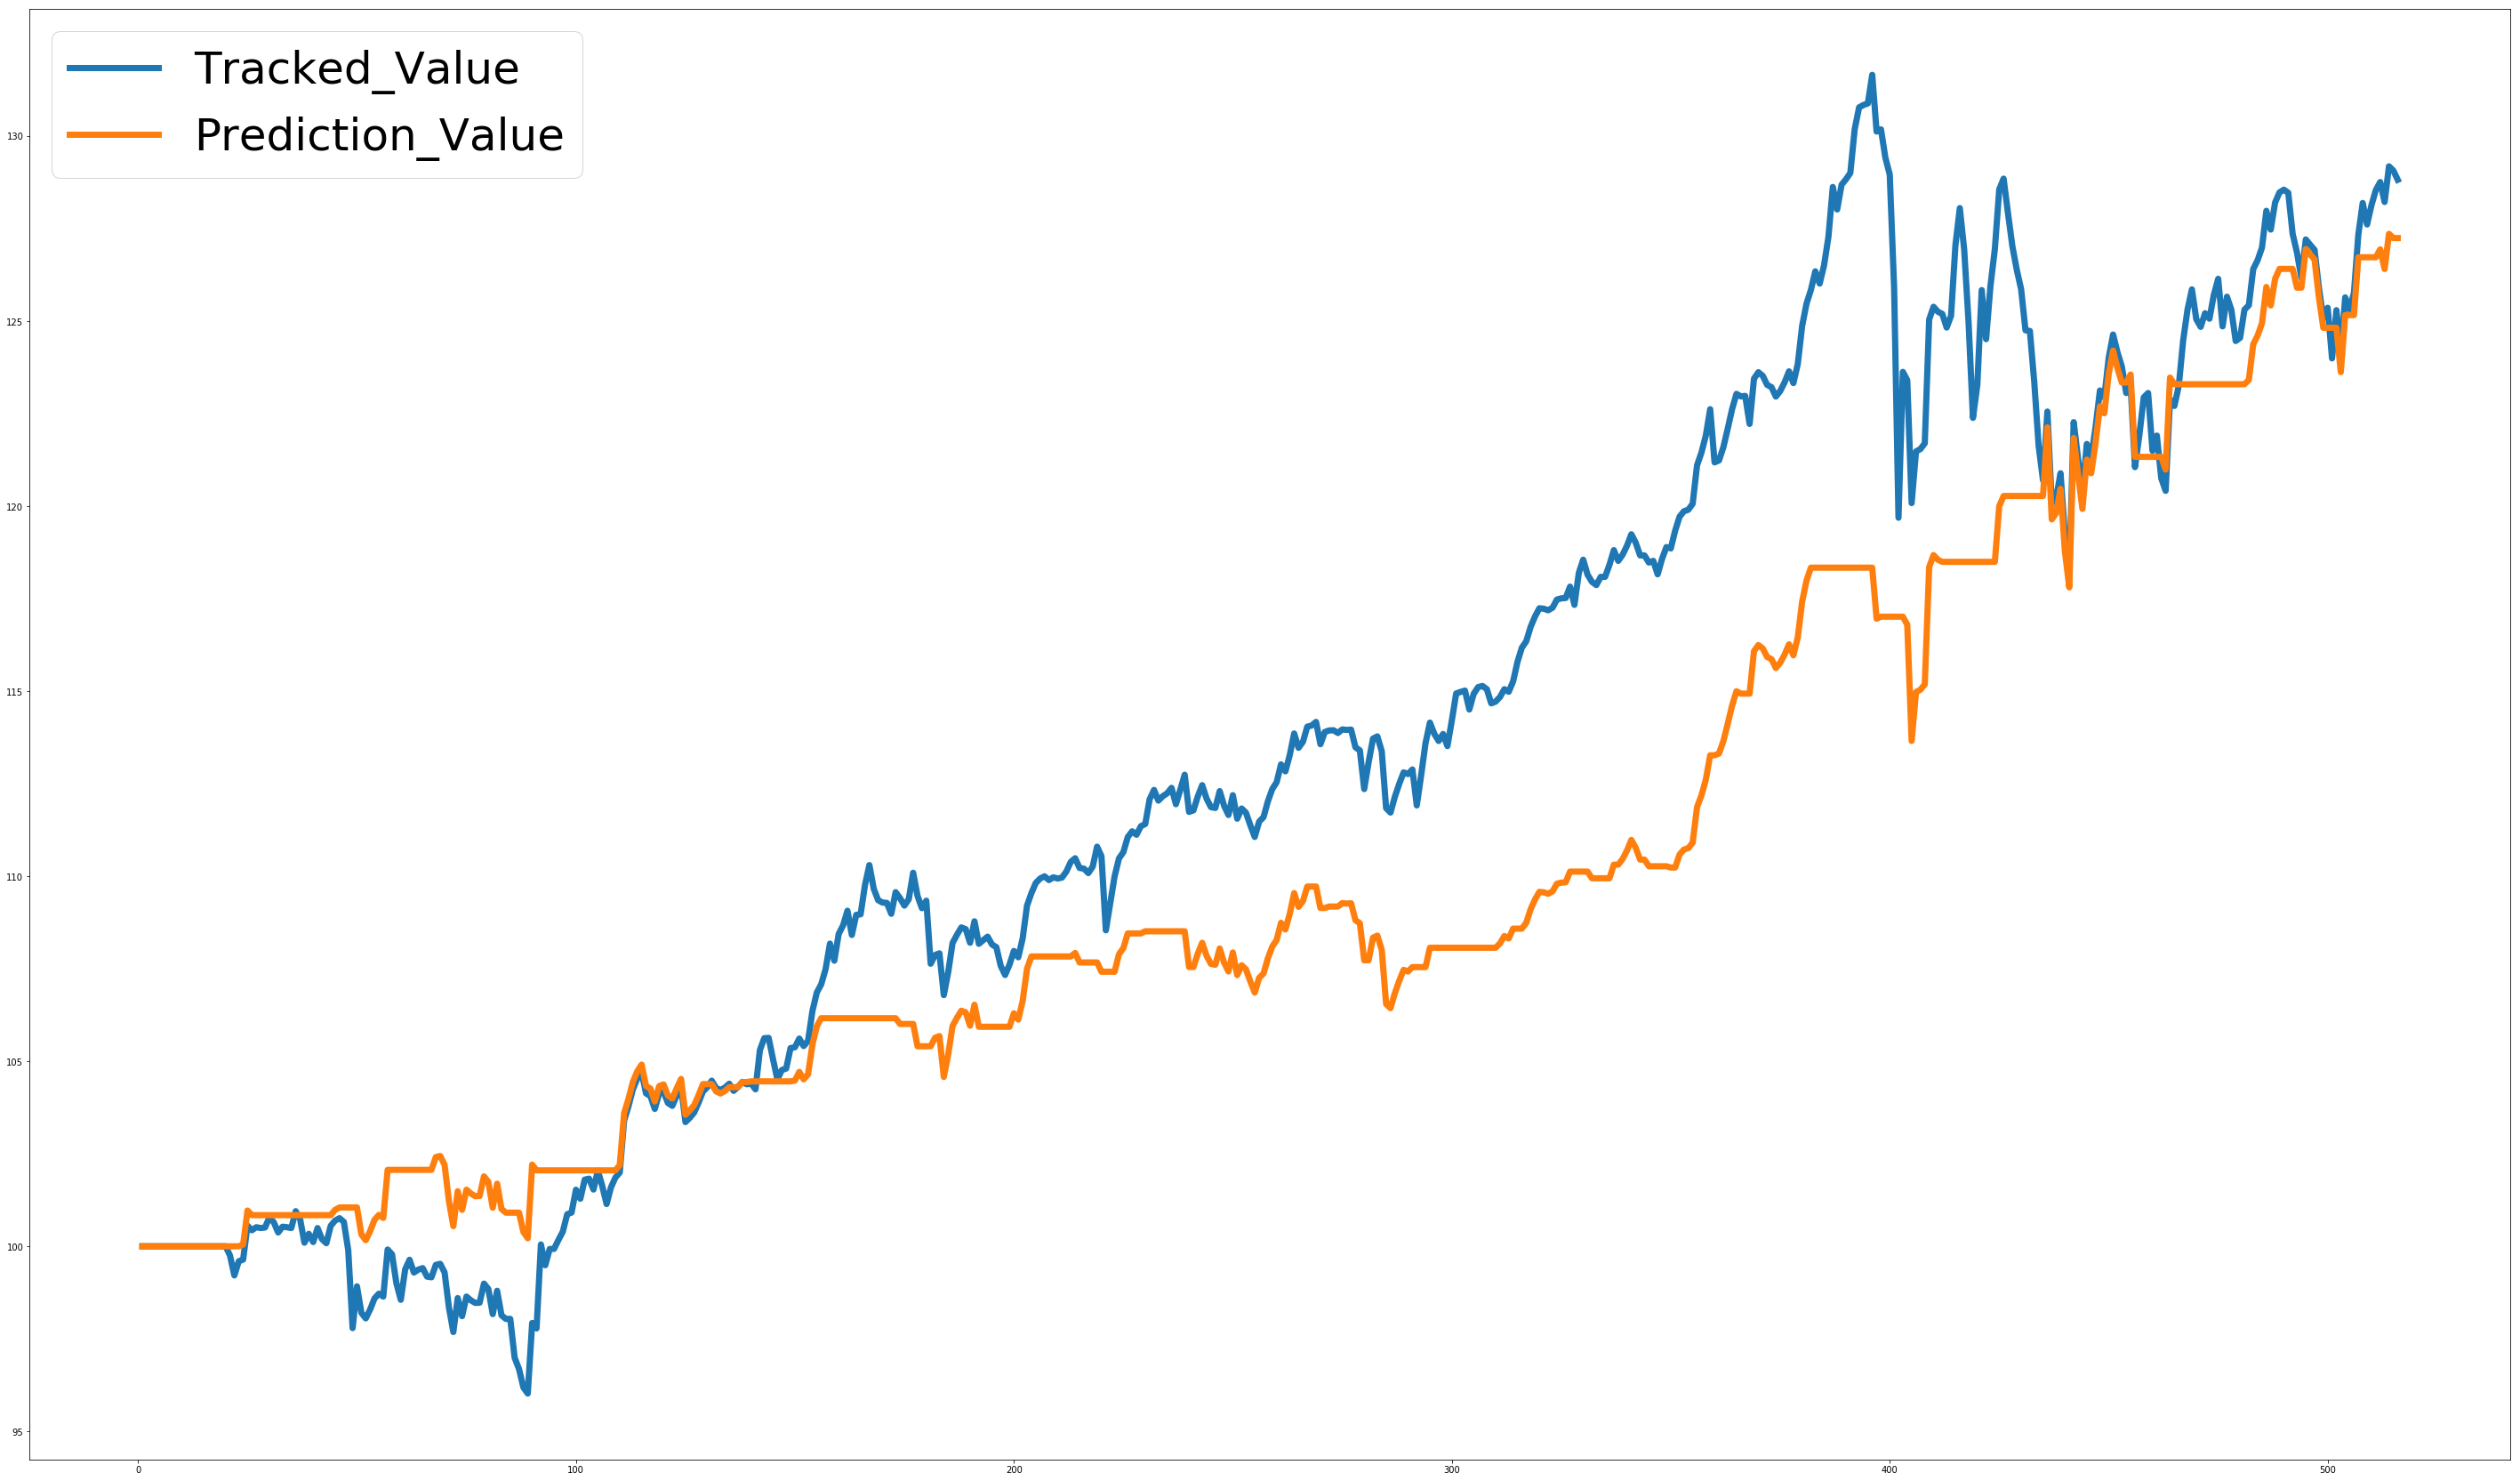

In [10]:
%pylab inline
pylab.rcParams['figure.figsize'] = (50, 30) 

plt.plot(dataset_results.Tracked_Value, linewidth=7.0)
plt.plot(dataset_results.Prediction_Value, linewidth=7.0)
#plt.plot(training_results.Tracked_Value, linewidth=7.0)
#plt.plot(training_results.Prediction_Value, linewidth=7.0)
#plt.plot(results.smart_value_1)
#plt.plot(results.smart_value_2)
#plt.plot(results.smart_value_3)
#plt.plot(results.smart_value_4)
#plt.plot(results.smart_value_5)
#plt.plot(results.smart_value_6)
#plt.plot(results.smart_value_7)
#plt.plot(results.smart_value_8)
#plt.plot(results.smart_value_9)
#plt.plot(results.smart_value_10)
plt.legend(loc=2, fontsize=50)
plt.show()

In [11]:
dataset_results.tail(10)

,date,price,LT,IT,ST,risk_zones,ST_x,ST_y,IT_x,IT_y,...,prediction_24,prediction_25,prediction_26,prediction_27,prediction_28,prediction_29,prediction_30,Average_Prediction,Prediction_Value,Tracked_Value
507,2018-07-09,276.55,6,3,3,33,0.707,-0.707,0.707,-0.707,...,1.02757,1.00133,0.974483,0.982149,0.988275,1.02543,0.994708,0.997923,126.721752,127.330908
508,2018-07-10,278.41,6,4,3,43,0.707,-0.707,0.000,-1.000,...,1.02179,0.999211,0.972782,0.968234,0.980874,1.01519,1.00664,0.994804,126.721752,128.187301
509,2018-07-11,277.15,6,4,3,43,0.707,-0.707,0.000,-1.000,...,1.02411,0.991079,0.970925,0.957859,0.982517,1.00655,1.00531,0.993855,126.721752,127.607164
510,2018-07-12,278.28,6,4,3,43,0.707,-0.707,0.000,-1.000,...,1.02405,0.982222,0.971334,0.952484,0.980824,1.00039,1.00359,0.992954,126.721752,128.127446
511,2018-07-13,279.17,6,4,4,44,0.000,-1.000,0.000,-1.000,...,1.00941,1.01556,0.984635,0.990491,0.991088,1.02059,1.00626,1.001667,126.721752,128.537225
512,2018-07-16,279.64,6,4,4,44,0.000,-1.000,0.000,-1.000,...,1.00535,1.01125,0.972266,0.98249,0.993607,1.02952,1.00378,1.001062,126.935096,128.753626
513,2018-07-17,278.47,6,4,4,44,0.000,-1.000,0.000,-1.000,...,1.00341,1.00525,0.968305,0.974691,0.995024,1.02537,1.00195,1.000411,126.404005,128.214927
514,2018-07-18,280.56,6,4,4,44,0.000,-1.000,0.000,-1.000,...,1.00459,0.999472,0.97128,0.970787,0.995069,1.01508,1.00013,1.000353,127.352705,129.177218
515,2018-07-19,280.31,6,4,4,44,0.000,-1.000,0.000,-1.000,...,1.00423,0.995477,0.973772,0.966782,0.995632,1.00259,0.999149,0.999523,127.239224,129.062112
516,2018-07-20,279.77,6,4,4,44,0.000,-1.000,0.000,-1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.239224,128.813481


In [50]:
# Write results to a csv
dataset_results.to_csv('QAS-LSTM-Model-v5.csv', sep=',')